In [13]:
import os
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.models import load_model


In [14]:
# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
VAL_IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "val")
VAL_LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "val")

# Constants
LIMIT_IMAGES = 100 # Number of images to sample
MAX_PIXELS = 10000  # Max number of pixels to process
LABEL_ID = 7  # Road label
BATCH_SIZE = 32 # Patch size
TARGET_SIZE = 256 # size of resample image width


In [15]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [16]:
def load_images_from_folder(images_dir, labels_dir):
    image_paths = []
    label_paths = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"): 
            image_paths.append(os.path.join(images_dir, filename))
            label_paths.append(os.path.join(labels_dir, filename.replace("leftImg8bit", "gtFine").replace(".png", "_label.png")))
    
    return image_paths, label_paths

In [17]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [18]:
import cv2
import numpy as np
import os
import tqdm

def image_label_generator(image_label_pairs, target_size=TARGET_SIZE, label_id=LABEL_ID, batch_size=BATCH_SIZE):
    while True:  # Keep generating images indefinitely
        X_batch = []  # List to store images in the current batch
        y_batch = []  # List to store labels in the current batch
        
        for image_path, label_path in tqdm.tqdm(image_label_pairs):
            # Read and resize the image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            h, w = image.shape[:2]

            # Calculate new height based on aspect ratio
            target_height = int((target_size / w) * h)

            # Resize the image
            image_resized = cv2.resize(image, (target_size, target_height))
            X_batch.append(image_resized)

            # Read and resize the label image
            label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            label_resized = cv2.resize(label_img, (target_size, target_height), interpolation=cv2.INTER_NEAREST)

            # Convert label to binary mask (for the target class)
            binary_label = (label_resized == label_id).astype(np.uint8)
            y_batch.append(binary_label)

            # If the batch size is met, yield the batch and reset the batch lists
            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)
                X_batch = []
                y_batch = []

        # If any remaining samples in the batch (less than batch_size), yield them
        if len(X_batch) > 0:
            yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)


In [19]:
def extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE):
    
    # Get training and validation image-label pairs
    train_image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
    val_image_label_pairs = get_image_label_pairs(VAL_IMAGES_DIR, VAL_LABELS_DIR)

    # Create generators for both training and validation data
    train_generator = image_label_generator(
        train_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )
    
    val_generator = image_label_generator(
        val_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )

    # This will just return the generators as we will use them for training
    return train_generator, val_generator


In [20]:
STEPS_PER_EPOCH = 1000

train_generator, val_generator = extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

In [21]:
from tensorflow.keras import layers, models

def build_fcn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Feature Extraction)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample

    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax' if num_classes > 1 else 'sigmoid')(x)

    # Model
    model = models.Model(inputs, outputs)
    return model


In [ ]:
model = load_model('model_fcn.keras')

In [25]:
from tensorflow.keras import optimizers, callbacks

def train_image_classifier_with_generator(train_generator, val_generator, steps_per_epoch, validation_steps, epochs=20, batch_size=32):
    # Build the full-image classifier
    input_shape = (128, 256, 3)  # Adjust as per your image dimensions (example size)
    model = build_fcn(input_shape, num_classes=1) 

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
        metrics=['accuracy']
    )

    # Define callbacks
    checkpoint_cb = callbacks.ModelCheckpoint("image_classifier_best.keras", save_best_only=True, monitor="val_loss", mode="min")
    early_stopping_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss", mode="min")

    # Train the model using the generators
    history = model.fit(
        train_generator, 
        steps_per_epoch=steps_per_epoch,  # Number of steps per epoch (e.g., len(train_image_label_pairs) // batch_size)
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,  # Number of steps for validation (similar to steps_per_epoch)
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )

    return model, history

# Example usage:
epochs = 10
batch_size = 32
steps_per_epoch = 100  # Adjust this based on your dataset size and batch size
validation_steps = 10  # Same as steps_per_epoch for validation, adjust as needed

# Assuming train_generator and val_generator are defined and working with your image-label pairs
model, history = train_image_classifier_with_generator(
    train_generator, 
    val_generator, 
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps, 
    epochs=epochs, 
    batch_size=batch_size,
)

# Check the model summary after training
model.summary()

 95%|█████████▌| 95/100 [00:12<00:00, 18.18it/s]

Epoch 1/4
  1/100 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 0.6218 - loss: 0.6539

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


  2/100 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.6319 - loss: 0.6596

  2%|▏         | 2/100 [00:00<00:11,  8.19it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 1:26 889ms/step - accuracy: 0.6352 - loss: 0.6601

 42%|████▏     | 42/100 [00:03<00:05,  9.69it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.6397 - loss: 0.6540   

 76%|███████▌  | 76/100 [00:05<00:02,  9.58it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.6434 - loss: 0.6460

  8%|▊         | 8/100 [00:00<00:10,  8.43it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.6460 - loss: 0.6390

 10%|█         | 10/100 [00:01<00:10,  8.94it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.6478 - loss: 0.6337

 43%|████▎     | 43/100 [00:03<00:05,  9.50it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.6495 - loss: 0.6280

 76%|███████▌  | 76/100 [00:06<00:02,  9.52it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.6511 - loss: 0.6220

  8%|▊         | 8/100 [00:00<00:10,  8.66it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.6523 - loss: 0.6163

  9%|▉         | 9/100 [00:00<00:10,  8.85it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.6533 - loss: 0.6115

 44%|████▍     | 44/100 [00:03<00:05,  9.72it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.6542 - loss: 0.6066

 77%|███████▋  | 77/100 [00:05<00:02, 10.50it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.6552 - loss: 0.6019

  8%|▊         | 8/100 [00:00<00:11,  8.28it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.6562 - loss: 0.5973

 10%|█         | 10/100 [00:01<00:10,  8.37it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.6570 - loss: 0.5933

 43%|████▎     | 43/100 [00:03<00:07,  7.83it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.6581 - loss: 0.5893

 75%|███████▌  | 75/100 [00:06<00:02,  8.83it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.6595 - loss: 0.5853

  6%|▌         | 6/100 [00:01<00:18,  4.95it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.6610 - loss: 0.5815

  8%|▊         | 8/100 [00:01<00:15,  5.91it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.6625 - loss: 0.5781

 43%|████▎     | 43/100 [00:04<00:09,  5.78it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.6642 - loss: 0.5747

 74%|███████▍  | 74/100 [00:08<00:04,  5.29it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.6661 - loss: 0.5713

 10%|█         | 10/100 [00:00<00:08, 10.30it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.6699 - loss: 0.5651

 44%|████▍     | 44/100 [00:03<00:05, 10.59it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.6719 - loss: 0.5622

 76%|███████▌  | 76/100 [00:05<00:02, 11.10it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.6740 - loss: 0.5593

  8%|▊         | 8/100 [00:00<00:08, 10.38it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.6760 - loss: 0.5565

 10%|█         | 10/100 [00:00<00:08, 10.94it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.6780 - loss: 0.5538

 45%|████▌     | 45/100 [00:03<00:04, 11.10it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.6800 - loss: 0.5513

 76%|███████▌  | 76/100 [00:05<00:02, 11.13it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.6820 - loss: 0.5488

  8%|▊         | 8/100 [00:00<00:08, 10.66it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.6840 - loss: 0.5463

 10%|█         | 10/100 [00:00<00:08, 10.36it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.6859 - loss: 0.5440

 44%|████▍     | 44/100 [00:03<00:05, 11.18it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.6878 - loss: 0.5417

 76%|███████▌  | 76/100 [00:05<00:02, 11.05it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.6897 - loss: 0.5394

  8%|▊         | 8/100 [00:00<00:08, 10.44it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.6916 - loss: 0.5372

 10%|█         | 10/100 [00:00<00:08, 10.64it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.6934 - loss: 0.5352

 44%|████▍     | 44/100 [00:03<00:05, 11.18it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.6952 - loss: 0.5331

 76%|███████▌  | 76/100 [00:06<00:04,  5.92it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.6970 - loss: 0.5311

  6%|▌         | 6/100 [00:01<00:16,  5.56it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.6988 - loss: 0.5291

  8%|▊         | 8/100 [00:01<00:14,  6.14it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.7004 - loss: 0.5272

 43%|████▎     | 43/100 [00:04<00:06,  8.78it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.7021 - loss: 0.5254

 76%|███████▌  | 76/100 [00:06<00:02,  9.84it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.7037 - loss: 0.5235

  7%|▋         | 7/100 [00:00<00:09,  9.50it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.7054 - loss: 0.5217

 10%|█         | 10/100 [00:01<00:08, 10.11it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.7069 - loss: 0.5200

 43%|████▎     | 43/100 [00:03<00:05, 11.38it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.7085 - loss: 0.5183

 74%|███████▍  | 74/100 [00:05<00:02, 10.37it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.7100 - loss: 0.5166

  7%|▋         | 7/100 [00:01<00:19,  4.83it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.7115 - loss: 0.5150

  9%|▉         | 9/100 [00:01<00:14,  6.29it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.7129 - loss: 0.5134

 44%|████▍     | 44/100 [00:05<00:12,  4.60it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.7143 - loss: 0.5119

 74%|███████▍  | 74/100 [00:08<00:04,  6.06it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.7156 - loss: 0.5103

  6%|▌         | 6/100 [00:00<00:11,  7.87it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.7169 - loss: 0.5089

  8%|▊         | 8/100 [00:01<00:11,  8.28it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.7182 - loss: 0.5074

 44%|████▍     | 44/100 [00:04<00:06,  8.86it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.7195 - loss: 0.5060

 76%|███████▌  | 76/100 [00:07<00:03,  7.49it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.7207 - loss: 0.5046

  6%|▌         | 6/100 [00:00<00:14,  6.39it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.7219 - loss: 0.5032

  8%|▊         | 8/100 [00:01<00:15,  5.81it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.7231 - loss: 0.5019

 43%|████▎     | 43/100 [00:04<00:07,  7.86it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.7243 - loss: 0.5006

 75%|███████▌  | 75/100 [00:06<00:02, 10.18it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.7254 - loss: 0.4992

  8%|▊         | 8/100 [00:01<00:12,  7.36it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.7276 - loss: 0.4967

 45%|████▌     | 45/100 [00:04<00:07,  7.74it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.7287 - loss: 0.4954

 75%|███████▌  | 75/100 [00:06<00:02,  9.81it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.7298 - loss: 0.4942

  8%|▊         | 8/100 [00:01<00:14,  6.27it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.7308 - loss: 0.4930

 10%|█         | 10/100 [00:01<00:12,  7.14it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.7318 - loss: 0.4918

 44%|████▍     | 44/100 [00:03<00:05, 10.70it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.7328 - loss: 0.4906

 74%|███████▍  | 74/100 [00:06<00:02,  9.62it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.7338 - loss: 0.4894

  8%|▊         | 8/100 [00:01<00:13,  6.75it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.7348 - loss: 0.4882

 10%|█         | 10/100 [00:01<00:11,  7.84it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.7358 - loss: 0.4871

 43%|████▎     | 43/100 [00:04<00:07,  7.41it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.7367 - loss: 0.4859

 76%|███████▌  | 76/100 [00:06<00:02,  8.64it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.7377 - loss: 0.4848

  7%|▋         | 7/100 [00:00<00:11,  8.37it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.7386 - loss: 0.4837

 10%|█         | 10/100 [00:01<00:10,  8.52it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7395 - loss: 0.4826 

 44%|████▍     | 44/100 [00:04<00:07,  7.52it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7404 - loss: 0.4815

 75%|███████▌  | 75/100 [00:07<00:03,  7.13it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7413 - loss: 0.4804

  8%|▊         | 8/100 [00:00<00:10,  9.13it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7422 - loss: 0.4793

 11%|█         | 11/100 [00:01<00:09,  9.28it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7430 - loss: 0.4783

 43%|████▎     | 43/100 [00:04<00:09,  6.10it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7438 - loss: 0.4772

 75%|███████▌  | 75/100 [00:07<00:03,  7.00it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7447 - loss: 0.4762

  7%|▋         | 7/100 [00:00<00:10,  9.16it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7455 - loss: 0.4752

 10%|█         | 10/100 [00:01<00:09,  9.20it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7463 - loss: 0.4742

 44%|████▍     | 44/100 [00:03<00:05, 10.85it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7471 - loss: 0.4732

 76%|███████▌  | 76/100 [00:05<00:02, 10.68it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7479 - loss: 0.4722

 10%|█         | 10/100 [00:00<00:08, 10.95it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7486 - loss: 0.4712

 12%|█▏        | 12/100 [00:01<00:07, 11.26it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7494 - loss: 0.4702

 44%|████▍     | 44/100 [00:03<00:04, 12.18it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7502 - loss: 0.4693

 75%|███████▌  | 75/100 [00:05<00:02, 11.22it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7509 - loss: 0.4683

  8%|▊         | 8/100 [00:00<00:09, 10.18it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7516 - loss: 0.4673

 10%|█         | 10/100 [00:00<00:07, 11.50it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7524 - loss: 0.4664

 44%|████▍     | 44/100 [00:03<00:04, 11.24it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7531 - loss: 0.4655

 75%|███████▌  | 75/100 [00:05<00:02, 11.21it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7538 - loss: 0.4646

  8%|▊         | 8/100 [00:00<00:08, 11.10it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7545 - loss: 0.4636

 10%|█         | 10/100 [00:00<00:08, 10.52it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7552 - loss: 0.4627

 44%|████▍     | 44/100 [00:03<00:04, 11.41it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7559 - loss: 0.4618

 75%|███████▌  | 75/100 [00:05<00:02, 11.96it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7565 - loss: 0.4610

  8%|▊         | 8/100 [00:00<00:08, 10.75it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7572 - loss: 0.4601

 10%|█         | 10/100 [00:00<00:07, 11.42it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7579 - loss: 0.4592

 43%|████▎     | 43/100 [00:03<00:05, 11.38it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7585 - loss: 0.4583 

 76%|███████▌  | 76/100 [00:05<00:02, 10.50it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7592 - loss: 0.4575

  9%|▉         | 9/100 [00:00<00:09, 10.07it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7598 - loss: 0.4567

 11%|█         | 11/100 [00:01<00:08, 10.72it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.7604 - loss: 0.4558

 43%|████▎     | 43/100 [00:03<00:05, 10.92it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7611 - loss: 0.4550

100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7617 - loss: 0.4542 - val_accuracy: 0.8896 - val_loss: 0.2637
Epoch 2/4


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


  1/100 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8731 - loss: 0.2936

 10%|█         | 10/100 [00:01<00:18,  4.78it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.8725 - loss: 0.2980

 12%|█▏        | 12/100 [00:02<00:18,  4.84it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.8726 - loss: 0.2989

 44%|████▍     | 44/100 [00:05<00:08,  6.53it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.8738 - loss: 0.2964

 76%|███████▌  | 76/100 [00:08<00:03,  6.89it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.8744 - loss: 0.2950

  7%|▋         | 7/100 [00:00<00:11,  7.91it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.8748 - loss: 0.2942

  9%|▉         | 9/100 [00:01<00:16,  5.50it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8751 - loss: 0.2936

 44%|████▍     | 44/100 [00:04<00:07,  7.62it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8753 - loss: 0.2930

 76%|███████▌  | 76/100 [00:07<00:03,  6.20it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8755 - loss: 0.2924

  7%|▋         | 7/100 [00:01<00:17,  5.35it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.8755 - loss: 0.2922

  8%|▊         | 8/100 [00:01<00:15,  5.98it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8755 - loss: 0.2921

 43%|████▎     | 43/100 [00:04<00:06,  9.01it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.8753 - loss: 0.2923

 76%|███████▌  | 76/100 [00:07<00:03,  7.55it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8751 - loss: 0.2924

  7%|▋         | 7/100 [00:01<00:15,  6.04it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.8749 - loss: 0.2927

  8%|▊         | 8/100 [00:01<00:13,  6.75it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8746 - loss: 0.2930

 44%|████▍     | 44/100 [00:04<00:07,  7.22it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.8745 - loss: 0.2930

 74%|███████▍  | 74/100 [00:06<00:02,  8.83it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.8744 - loss: 0.2930

  8%|▊         | 8/100 [00:00<00:08, 10.45it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.8743 - loss: 0.2931

 10%|█         | 10/100 [00:00<00:09,  9.58it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8742 - loss: 0.2931

 43%|████▎     | 43/100 [00:03<00:08,  7.06it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.8742 - loss: 0.2930

 74%|███████▍  | 74/100 [00:06<00:03,  6.77it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8742 - loss: 0.2928

  8%|▊         | 8/100 [00:01<00:11,  8.21it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8742 - loss: 0.2927

  9%|▉         | 9/100 [00:01<00:11,  7.90it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.8743 - loss: 0.2925

 42%|████▏     | 42/100 [00:03<00:06,  9.58it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8743 - loss: 0.2922

 75%|███████▌  | 75/100 [00:06<00:03,  6.52it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8744 - loss: 0.2920

  7%|▋         | 7/100 [00:00<00:13,  7.13it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.8745 - loss: 0.2917

  9%|▉         | 9/100 [00:01<00:13,  6.80it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8746 - loss: 0.2914

 43%|████▎     | 43/100 [00:04<00:07,  8.03it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8747 - loss: 0.2911

 74%|███████▍  | 74/100 [00:06<00:02,  9.38it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8748 - loss: 0.2908

  7%|▋         | 7/100 [00:00<00:09,  9.42it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8749 - loss: 0.2906

  9%|▉         | 9/100 [00:00<00:10,  8.98it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8750 - loss: 0.2903

 43%|████▎     | 43/100 [00:03<00:05,  9.71it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8751 - loss: 0.2900

 75%|███████▌  | 75/100 [00:05<00:02,  9.40it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8752 - loss: 0.2897

  8%|▊         | 8/100 [00:01<00:16,  5.66it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8753 - loss: 0.2895

 10%|█         | 10/100 [00:01<00:14,  6.00it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.8753 - loss: 0.2893

 44%|████▍     | 44/100 [00:05<00:08,  6.48it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8753 - loss: 0.2891

 75%|███████▌  | 75/100 [00:08<00:03,  7.78it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.8753 - loss: 0.2890

  6%|▌         | 6/100 [00:00<00:15,  6.13it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8753 - loss: 0.2889

  8%|▊         | 8/100 [00:01<00:14,  6.20it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8753 - loss: 0.2889

 43%|████▎     | 43/100 [00:04<00:08,  6.38it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8754 - loss: 0.2888

 75%|███████▌  | 75/100 [00:08<00:04,  6.21it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8754 - loss: 0.2887

  7%|▋         | 7/100 [00:01<00:17,  5.43it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8754 - loss: 0.2886

  9%|▉         | 9/100 [00:01<00:16,  5.49it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8754 - loss: 0.2885

 44%|████▍     | 44/100 [00:05<00:07,  7.33it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8754 - loss: 0.2884

 76%|███████▌  | 76/100 [00:08<00:03,  6.23it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.8754 - loss: 0.2882

  8%|▊         | 8/100 [00:00<00:12,  7.62it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.8755 - loss: 0.2881

  9%|▉         | 9/100 [00:01<00:14,  6.25it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8755 - loss: 0.2880

 45%|████▌     | 45/100 [00:04<00:06,  8.95it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8755 - loss: 0.2879

 75%|███████▌  | 75/100 [00:07<00:03,  6.91it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.8756 - loss: 0.2878

  7%|▋         | 7/100 [00:01<00:19,  4.74it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.8756 - loss: 0.2877

  9%|▉         | 9/100 [00:01<00:17,  5.18it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8756 - loss: 0.2876

 44%|████▍     | 44/100 [00:05<00:09,  5.93it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.8756 - loss: 0.2875

 75%|███████▌  | 75/100 [00:08<00:03,  6.78it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8757 - loss: 0.2874

  7%|▋         | 7/100 [00:00<00:13,  6.80it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.8757 - loss: 0.2873

  9%|▉         | 9/100 [00:01<00:18,  4.95it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8757 - loss: 0.2872

 43%|████▎     | 43/100 [00:05<00:10,  5.37it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.8757 - loss: 0.2871

 76%|███████▌  | 76/100 [00:08<00:03,  8.00it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.8758 - loss: 0.2870

  8%|▊         | 8/100 [00:00<00:12,  7.31it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8758 - loss: 0.2869

  9%|▉         | 9/100 [00:01<00:11,  7.68it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.8758 - loss: 0.2868

 44%|████▍     | 44/100 [00:04<00:06,  8.43it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.8759 - loss: 0.2867

 75%|███████▌  | 75/100 [00:07<00:03,  6.60it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8759 - loss: 0.2865

  6%|▌         | 6/100 [00:01<00:17,  5.28it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8760 - loss: 0.2864

  9%|▉         | 9/100 [00:01<00:13,  6.58it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.8760 - loss: 0.2863

 44%|████▍     | 44/100 [00:04<00:08,  6.59it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8761 - loss: 0.2861

 74%|███████▍  | 74/100 [00:08<00:04,  5.44it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8762 - loss: 0.2860

  7%|▋         | 7/100 [00:01<00:15,  6.02it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.8762 - loss: 0.2858

  8%|▊         | 8/100 [00:01<00:14,  6.34it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8763 - loss: 0.2857

 44%|████▍     | 44/100 [00:04<00:06,  8.25it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.8763 - loss: 0.2855

 76%|███████▌  | 76/100 [00:07<00:02,  8.50it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8764 - loss: 0.2854

  7%|▋         | 7/100 [00:00<00:13,  6.74it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.8765 - loss: 0.2852

  9%|▉         | 9/100 [00:01<00:12,  7.54it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8765 - loss: 0.2851

 44%|████▍     | 44/100 [00:04<00:05,  9.49it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.8766 - loss: 0.2849

 74%|███████▍  | 74/100 [00:06<00:03,  6.69it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8766 - loss: 0.2848

  7%|▋         | 7/100 [00:01<00:14,  6.36it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8767 - loss: 0.2846

  9%|▉         | 9/100 [00:01<00:17,  5.09it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8768 - loss: 0.2845 

 44%|████▍     | 44/100 [00:04<00:06,  8.04it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8768 - loss: 0.2843

 75%|███████▌  | 75/100 [00:07<00:02,  8.58it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8769 - loss: 0.2842

  7%|▋         | 7/100 [00:00<00:12,  7.37it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8769 - loss: 0.2840

  9%|▉         | 9/100 [00:01<00:12,  7.07it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8770 - loss: 0.2839

 43%|████▎     | 43/100 [00:03<00:06,  8.54it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8771 - loss: 0.2838

 75%|███████▌  | 75/100 [00:06<00:02,  9.60it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8771 - loss: 0.2836

  8%|▊         | 8/100 [00:00<00:12,  7.53it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8772 - loss: 0.2835

 10%|█         | 10/100 [00:01<00:11,  8.02it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8772 - loss: 0.2833

 43%|████▎     | 43/100 [00:03<00:06,  8.72it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8773 - loss: 0.2832

 74%|███████▍  | 74/100 [00:06<00:02,  9.54it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8774 - loss: 0.2830

  8%|▊         | 8/100 [00:00<00:12,  7.55it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8774 - loss: 0.2829

  9%|▉         | 9/100 [00:01<00:13,  6.53it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8775 - loss: 0.2827

 44%|████▍     | 44/100 [00:04<00:06,  8.68it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8775 - loss: 0.2826

 76%|███████▌  | 76/100 [00:06<00:02,  8.82it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8776 - loss: 0.2825

  9%|▉         | 9/100 [00:01<00:10,  8.46it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8777 - loss: 0.2823

 10%|█         | 10/100 [00:01<00:14,  6.39it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8777 - loss: 0.2822

 43%|████▎     | 43/100 [00:04<00:06,  8.64it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8778 - loss: 0.2821

 76%|███████▌  | 76/100 [00:06<00:02,  9.00it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8778 - loss: 0.2820

  7%|▋         | 7/100 [00:00<00:12,  7.68it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8779 - loss: 0.2819

  9%|▉         | 9/100 [00:01<00:13,  6.54it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8779 - loss: 0.2818

 43%|████▎     | 43/100 [00:03<00:05,  9.71it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8780 - loss: 0.2816 

 75%|███████▌  | 75/100 [00:07<00:04,  6.07it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8780 - loss: 0.2815

  8%|▊         | 8/100 [00:00<00:12,  7.54it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8781 - loss: 0.2814

  9%|▉         | 9/100 [00:01<00:11,  7.70it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8781 - loss: 0.2813

 44%|████▍     | 44/100 [00:04<00:06,  8.75it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8782 - loss: 0.2812

100%|██████████| 100/100 [00:05<00:00, 16.72it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.8782 - loss: 0.2810 - val_accuracy: 0.9124 - val_loss: 0.2146



  3%|▎         | 3/100 [00:00<00:07, 12.71it/s]

Epoch 3/4


 44%|████▍     | 44/100 [00:11<00:13,  4.16it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.8995 - loss: 0.2310

 56%|█████▌    | 56/100 [00:12<00:06,  6.49it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8973 - loss: 0.2369

 58%|█████▊    | 58/100 [00:13<00:07,  5.65it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.8971 - loss: 0.2377

 70%|███████   | 70/100 [00:15<00:05,  5.92it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.8969 - loss: 0.2385

 81%|████████  | 81/100 [00:16<00:03,  6.26it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.8971 - loss: 0.2385

  7%|▋         | 7/100 [00:00<00:13,  7.01it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8966 - loss: 0.2394

  9%|▉         | 9/100 [00:01<00:16,  5.48it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - accuracy: 0.8964 - loss: 0.2398

 43%|████▎     | 43/100 [00:04<00:08,  6.56it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.8962 - loss: 0.2403

 75%|███████▌  | 75/100 [00:07<00:03,  7.87it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8961 - loss: 0.2404

  7%|▋         | 7/100 [00:00<00:11,  8.11it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8958 - loss: 0.2409

  9%|▉         | 9/100 [00:01<00:13,  6.76it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8957 - loss: 0.2412

 43%|████▎     | 43/100 [00:04<00:11,  5.16it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.8957 - loss: 0.2413

 75%|███████▌  | 75/100 [00:07<00:03,  7.66it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8958 - loss: 0.2412

  8%|▊         | 8/100 [00:01<00:14,  6.31it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8959 - loss: 0.2411

  9%|▉         | 9/100 [00:01<00:15,  5.88it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.8960 - loss: 0.2409

 43%|████▎     | 43/100 [00:04<00:08,  6.36it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.8961 - loss: 0.2406

 74%|███████▍  | 74/100 [00:07<00:03,  6.99it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8963 - loss: 0.2402

  8%|▊         | 8/100 [00:01<00:12,  7.51it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.8966 - loss: 0.2399

  9%|▉         | 9/100 [00:01<00:14,  6.20it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.8968 - loss: 0.2395

 44%|████▍     | 44/100 [00:04<00:06,  9.00it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.8970 - loss: 0.2391

 77%|███████▋  | 77/100 [00:06<00:02,  9.43it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.8972 - loss: 0.2386

  8%|▊         | 8/100 [00:00<00:11,  8.05it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.8975 - loss: 0.2381

 11%|█         | 11/100 [00:01<00:11,  8.00it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8977 - loss: 0.2377

 43%|████▎     | 43/100 [00:03<00:06,  8.55it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8980 - loss: 0.2372

 75%|███████▌  | 75/100 [00:06<00:02,  9.64it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8982 - loss: 0.2368

  7%|▋         | 7/100 [00:00<00:12,  7.41it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8984 - loss: 0.2363

  8%|▊         | 8/100 [00:01<00:12,  7.57it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8987 - loss: 0.2358

 42%|████▏     | 42/100 [00:03<00:06,  9.28it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8989 - loss: 0.2354

 75%|███████▌  | 75/100 [00:06<00:02,  9.17it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8991 - loss: 0.2350

  7%|▋         | 7/100 [00:00<00:12,  7.50it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8993 - loss: 0.2346

  9%|▉         | 9/100 [00:01<00:13,  6.66it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8995 - loss: 0.2342

 44%|████▍     | 44/100 [00:04<00:06,  8.21it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8997 - loss: 0.2338

 75%|███████▌  | 75/100 [00:06<00:02,  8.54it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8999 - loss: 0.2334

  8%|▊         | 8/100 [00:00<00:11,  8.04it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.9000 - loss: 0.2332

 10%|█         | 10/100 [00:01<00:13,  6.48it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.9002 - loss: 0.2329

 44%|████▍     | 44/100 [00:04<00:06,  8.54it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.9003 - loss: 0.2327

 75%|███████▌  | 75/100 [00:06<00:02,  8.69it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.9003 - loss: 0.2326

  7%|▋         | 7/100 [00:00<00:11,  7.80it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.9004 - loss: 0.2325

  9%|▉         | 9/100 [00:01<00:11,  8.03it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.9004 - loss: 0.2324

 44%|████▍     | 44/100 [00:04<00:06,  9.32it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.9005 - loss: 0.2323

 75%|███████▌  | 75/100 [00:06<00:02,  8.59it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.9005 - loss: 0.2323

  7%|▋         | 7/100 [00:00<00:11,  7.83it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.9006 - loss: 0.2322

  9%|▉         | 9/100 [00:01<00:12,  7.08it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.9006 - loss: 0.2321

 44%|████▍     | 44/100 [00:04<00:06,  8.90it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.9006 - loss: 0.2321

 75%|███████▌  | 75/100 [00:06<00:02,  8.51it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.9006 - loss: 0.2320

  8%|▊         | 8/100 [00:00<00:11,  8.12it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.9007 - loss: 0.2320

 10%|█         | 10/100 [00:01<00:13,  6.46it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.9007 - loss: 0.2319

 43%|████▎     | 43/100 [00:04<00:06,  8.49it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.9007 - loss: 0.2319

 76%|███████▌  | 76/100 [00:06<00:02,  8.59it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.9008 - loss: 0.2318

  8%|▊         | 8/100 [00:00<00:11,  7.70it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.9008 - loss: 0.2318

 10%|█         | 10/100 [00:01<00:10,  8.81it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.9008 - loss: 0.2318

 44%|████▍     | 44/100 [00:03<00:06,  8.91it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.9007 - loss: 0.2319

 76%|███████▌  | 76/100 [00:06<00:02,  9.75it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.9007 - loss: 0.2320

  8%|▊         | 8/100 [00:00<00:10,  8.94it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.9006 - loss: 0.2321

 10%|█         | 10/100 [00:00<00:08, 10.02it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.9006 - loss: 0.2322

 44%|████▍     | 44/100 [00:03<00:05,  9.88it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.9005 - loss: 0.2323

 74%|███████▍  | 74/100 [00:05<00:02,  9.27it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.9004 - loss: 0.2325

  8%|▊         | 8/100 [00:00<00:10,  8.67it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.9003 - loss: 0.2328

 44%|████▍     | 44/100 [00:03<00:06,  8.96it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.9002 - loss: 0.2330

 74%|███████▍  | 74/100 [00:06<00:02,  8.94it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.9001 - loss: 0.2331

  8%|▊         | 8/100 [00:00<00:11,  8.32it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.9000 - loss: 0.2333

 10%|█         | 10/100 [00:01<00:09,  9.48it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.9000 - loss: 0.2335

 44%|████▍     | 44/100 [00:03<00:05,  9.95it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8999 - loss: 0.2336

 74%|███████▍  | 74/100 [00:05<00:02,  9.43it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8998 - loss: 0.2338

  8%|▊         | 8/100 [00:00<00:10,  8.46it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.8998 - loss: 0.2339

 10%|█         | 10/100 [00:01<00:10,  8.81it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8997 - loss: 0.2340

 44%|████▍     | 44/100 [00:03<00:05,  9.99it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.8996 - loss: 0.2342

 75%|███████▌  | 75/100 [00:06<00:02,  8.59it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.8996 - loss: 0.2343

  8%|▊         | 8/100 [00:00<00:11,  7.86it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8995 - loss: 0.2344

 10%|█         | 10/100 [00:01<00:12,  7.44it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8995 - loss: 0.2345 

 44%|████▍     | 44/100 [00:03<00:06,  9.07it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8994 - loss: 0.2346

 76%|███████▌  | 76/100 [00:06<00:02,  9.28it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8994 - loss: 0.2347

  7%|▋         | 7/100 [00:00<00:12,  7.48it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8993 - loss: 0.2348

  8%|▊         | 8/100 [00:00<00:11,  8.07it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8993 - loss: 0.2349

 44%|████▍     | 44/100 [00:03<00:06,  9.16it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8993 - loss: 0.2349

 74%|███████▍  | 74/100 [00:06<00:02,  9.42it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8992 - loss: 0.2350

  7%|▋         | 7/100 [00:00<00:10,  8.48it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8992 - loss: 0.2351

  9%|▉         | 9/100 [00:01<00:11,  8.14it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8992 - loss: 0.2351

 43%|████▎     | 43/100 [00:03<00:06,  9.50it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8991 - loss: 0.2352

 75%|███████▌  | 75/100 [00:05<00:02,  9.50it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8991 - loss: 0.2352

  8%|▊         | 8/100 [00:00<00:10,  8.89it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8991 - loss: 0.2353

 10%|█         | 10/100 [00:01<00:09,  9.74it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8991 - loss: 0.2353

 43%|████▎     | 43/100 [00:03<00:06,  8.57it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8991 - loss: 0.2354

 76%|███████▌  | 76/100 [00:06<00:02,  9.16it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8991 - loss: 0.2354

  7%|▋         | 7/100 [00:00<00:11,  7.85it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8991 - loss: 0.2354

  9%|▉         | 9/100 [00:01<00:09,  9.19it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8991 - loss: 0.2354

 43%|████▎     | 43/100 [00:03<00:05,  9.64it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8990 - loss: 0.2354

 77%|███████▋  | 77/100 [00:06<00:02,  9.64it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8991 - loss: 0.2354

  7%|▋         | 7/100 [00:00<00:11,  8.06it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8991 - loss: 0.2354

 10%|█         | 10/100 [00:01<00:09,  9.73it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8991 - loss: 0.2354

 44%|████▍     | 44/100 [00:03<00:06,  9.07it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8991 - loss: 0.2354

 74%|███████▍  | 74/100 [00:06<00:02,  9.33it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8991 - loss: 0.2353

  6%|▌         | 6/100 [00:00<00:11,  7.84it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8991 - loss: 0.2353

  8%|▊         | 8/100 [00:01<00:11,  7.76it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8991 - loss: 0.2353

 44%|████▍     | 44/100 [00:03<00:05,  9.75it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8991 - loss: 0.2352 

 76%|███████▌  | 76/100 [00:06<00:02,  9.68it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8992 - loss: 0.2352

  9%|▉         | 9/100 [00:00<00:09,  9.47it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8992 - loss: 0.2351

 11%|█         | 11/100 [00:01<00:08, 10.43it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8992 - loss: 0.2351

 43%|████▎     | 43/100 [00:03<00:05,  9.51it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8992 - loss: 0.2350

 30%|███       | 30/100 [00:01<00:04, 16.72it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8993 - loss: 0.2350 - val_accuracy: 0.9229 - val_loss: 0.1945
Epoch 4/4


 45%|████▌     | 45/100 [00:04<00:07,  7.01it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.9247 - loss: 0.1750

 56%|█████▌    | 56/100 [00:06<00:06,  6.42it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.9242 - loss: 0.1777

 58%|█████▊    | 58/100 [00:06<00:07,  5.42it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9248 - loss: 0.1771

 69%|██████▉   | 69/100 [00:08<00:04,  6.76it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.9253 - loss: 0.1767

 80%|████████  | 80/100 [00:10<00:02,  7.39it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.9254 - loss: 0.1768

 92%|█████████▏| 92/100 [00:11<00:01,  7.38it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.9251 - loss: 0.1778

 94%|█████████▍| 94/100 [00:11<00:00,  8.07it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.9251 - loss: 0.1783

  6%|▌         | 6/100 [00:01<00:17,  5.47it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9249 - loss: 0.1787

 16%|█▌        | 16/100 [00:02<00:13,  6.06it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.9248 - loss: 0.1790

 27%|██▋       | 27/100 [00:04<00:10,  7.28it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.9247 - loss: 0.1792

 29%|██▉       | 29/100 [00:04<00:09,  7.58it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9247 - loss: 0.1793

 44%|████▍     | 44/100 [00:06<00:06,  8.21it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9248 - loss: 0.1792

 74%|███████▍  | 74/100 [00:08<00:02,  9.51it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9248 - loss: 0.1792

  8%|▊         | 8/100 [00:00<00:10,  8.89it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.9249 - loss: 0.1791

 10%|█         | 10/100 [00:01<00:10,  8.48it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9249 - loss: 0.1790

 42%|████▏     | 42/100 [00:03<00:06,  9.37it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.9250 - loss: 0.1788

 74%|███████▍  | 74/100 [00:06<00:02,  9.53it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.9251 - loss: 0.1786

  9%|▉         | 9/100 [00:00<00:10,  8.92it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.9252 - loss: 0.1783

 11%|█         | 11/100 [00:01<00:09,  8.98it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.9254 - loss: 0.1781

 43%|████▎     | 43/100 [00:03<00:06,  8.30it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.9255 - loss: 0.1778

 75%|███████▌  | 75/100 [00:06<00:02,  8.55it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.9256 - loss: 0.1775

  8%|▊         | 8/100 [00:00<00:11,  8.07it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.9257 - loss: 0.1773

 10%|█         | 10/100 [00:01<00:10,  8.30it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.9259 - loss: 0.1770

 44%|████▍     | 44/100 [00:03<00:06,  8.39it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.9260 - loss: 0.1768

 76%|███████▌  | 76/100 [00:06<00:02,  9.02it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.9261 - loss: 0.1766

  7%|▋         | 7/100 [00:00<00:11,  8.12it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.9262 - loss: 0.1763

  9%|▉         | 9/100 [00:01<00:11,  7.85it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.9263 - loss: 0.1761

 44%|████▍     | 44/100 [00:03<00:06,  9.06it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.9264 - loss: 0.1759

 74%|███████▍  | 74/100 [00:06<00:03,  8.47it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.9265 - loss: 0.1756

  8%|▊         | 8/100 [00:00<00:11,  7.72it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.9266 - loss: 0.1754

 10%|█         | 10/100 [00:01<00:10,  8.85it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.9267 - loss: 0.1751

 44%|████▍     | 44/100 [00:03<00:05,  9.37it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.9269 - loss: 0.1749

 74%|███████▍  | 74/100 [00:06<00:02,  9.48it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.9270 - loss: 0.1746

  7%|▋         | 7/100 [00:00<00:12,  7.59it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.9271 - loss: 0.1744

  9%|▉         | 9/100 [00:01<00:10,  8.94it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.9272 - loss: 0.1742

 44%|████▍     | 44/100 [00:03<00:05, 10.13it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.9273 - loss: 0.1739

 75%|███████▌  | 75/100 [00:06<00:02,  8.41it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.9274 - loss: 0.1737

  8%|▊         | 8/100 [00:00<00:10,  8.48it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.9275 - loss: 0.1735

 10%|█         | 10/100 [00:01<00:11,  8.07it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.9276 - loss: 0.1734

 44%|████▍     | 44/100 [00:03<00:05,  9.40it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - accuracy: 0.9276 - loss: 0.1732

 74%|███████▍  | 74/100 [00:06<00:02,  9.31it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.9277 - loss: 0.1731

  8%|▊         | 8/100 [00:00<00:10,  8.50it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.9277 - loss: 0.1730

 10%|█         | 10/100 [00:01<00:09,  9.37it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.9278 - loss: 0.1729

 43%|████▎     | 43/100 [00:03<00:06,  9.28it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.9278 - loss: 0.1728

 75%|███████▌  | 75/100 [00:06<00:02,  8.71it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.9279 - loss: 0.1727

  6%|▌         | 6/100 [00:00<00:12,  7.74it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.9279 - loss: 0.1726

  8%|▊         | 8/100 [00:01<00:12,  7.38it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.9280 - loss: 0.1725

 44%|████▍     | 44/100 [00:03<00:06,  8.85it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.9280 - loss: 0.1725

 74%|███████▍  | 74/100 [00:06<00:02,  9.32it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.9280 - loss: 0.1724

  7%|▋         | 7/100 [00:00<00:11,  7.76it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.9281 - loss: 0.1723

  9%|▉         | 9/100 [00:01<00:10,  8.29it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.9281 - loss: 0.1723

 43%|████▎     | 43/100 [00:03<00:05,  9.54it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.9281 - loss: 0.1722

 75%|███████▌  | 75/100 [00:06<00:02,  9.07it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.9281 - loss: 0.1722

  7%|▋         | 7/100 [00:00<00:11,  8.31it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.9282 - loss: 0.1721

  9%|▉         | 9/100 [00:01<00:11,  8.25it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.9282 - loss: 0.1721

 43%|████▎     | 43/100 [00:03<00:05,  9.93it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.9282 - loss: 0.1720

 75%|███████▌  | 75/100 [00:06<00:02,  9.84it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.9283 - loss: 0.1720

  8%|▊         | 8/100 [00:00<00:12,  7.62it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.9283 - loss: 0.1718

 44%|████▍     | 44/100 [00:03<00:05,  9.47it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.9283 - loss: 0.1718

 75%|███████▌  | 75/100 [00:06<00:02,  8.44it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.9284 - loss: 0.1717

  8%|▊         | 8/100 [00:00<00:12,  7.29it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.9284 - loss: 0.1717

 10%|█         | 10/100 [00:01<00:11,  7.54it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.9284 - loss: 0.1716

 43%|████▎     | 43/100 [00:03<00:05, 10.01it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.9284 - loss: 0.1716

 77%|███████▋  | 77/100 [00:06<00:02,  9.45it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.9285 - loss: 0.1715

  9%|▉         | 9/100 [00:00<00:10,  8.76it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.9285 - loss: 0.1715

 11%|█         | 11/100 [00:01<00:09,  9.86it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.9285 - loss: 0.1714

 44%|████▍     | 44/100 [00:03<00:06,  8.35it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9285 - loss: 0.1714 

 76%|███████▌  | 76/100 [00:06<00:02,  9.32it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9285 - loss: 0.1714

  7%|▋         | 7/100 [00:00<00:10,  8.47it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9285 - loss: 0.1714

  9%|▉         | 9/100 [00:01<00:11,  8.17it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9285 - loss: 0.1714

 44%|████▍     | 44/100 [00:03<00:06,  8.91it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9285 - loss: 0.1714

 74%|███████▍  | 74/100 [00:05<00:02,  9.20it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9285 - loss: 0.1714

  9%|▉         | 9/100 [00:00<00:10,  8.68it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9285 - loss: 0.1714

 11%|█         | 11/100 [00:01<00:09,  9.10it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9285 - loss: 0.1714

 44%|████▍     | 44/100 [00:03<00:06,  8.69it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9285 - loss: 0.1714

 76%|███████▌  | 76/100 [00:06<00:02,  8.82it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9285 - loss: 0.1714

  7%|▋         | 7/100 [00:00<00:12,  7.41it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9285 - loss: 0.1714

  8%|▊         | 8/100 [00:01<00:11,  7.97it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9285 - loss: 0.1714

 43%|████▎     | 43/100 [00:03<00:06,  9.18it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9285 - loss: 0.1714

 75%|███████▌  | 75/100 [00:06<00:02,  9.60it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9285 - loss: 0.1714

  8%|▊         | 8/100 [00:00<00:11,  8.29it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9285 - loss: 0.1714

 10%|█         | 10/100 [00:01<00:10,  8.19it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9285 - loss: 0.1714

 44%|████▍     | 44/100 [00:03<00:05,  9.66it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9285 - loss: 0.1714

 76%|███████▌  | 76/100 [00:06<00:02,  9.87it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9285 - loss: 0.1714

  7%|▋         | 7/100 [00:00<00:12,  7.55it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9285 - loss: 0.1714

  9%|▉         | 9/100 [00:01<00:11,  7.76it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9285 - loss: 0.1714

 43%|████▎     | 43/100 [00:03<00:05,  9.52it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9285 - loss: 0.1715

 75%|███████▌  | 75/100 [00:06<00:02,  8.73it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9284 - loss: 0.1715

  7%|▋         | 7/100 [00:00<00:12,  7.24it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9284 - loss: 0.1716

  8%|▊         | 8/100 [00:01<00:11,  7.79it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9284 - loss: 0.1717

 42%|████▏     | 42/100 [00:03<00:06,  9.45it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9283 - loss: 0.1718

 76%|███████▌  | 76/100 [00:06<00:02,  9.32it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9283 - loss: 0.1719

  8%|▊         | 8/100 [00:00<00:11,  8.04it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9282 - loss: 0.1720

 10%|█         | 10/100 [00:01<00:10,  8.63it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9282 - loss: 0.1721 

 44%|████▍     | 44/100 [00:03<00:06,  9.12it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9281 - loss: 0.1722

 74%|███████▍  | 74/100 [00:06<00:02,  9.61it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9281 - loss: 0.1723

  8%|▊         | 8/100 [00:00<00:10,  8.47it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9280 - loss: 0.1724

  9%|▉         | 9/100 [00:00<00:10,  8.64it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9280 - loss: 0.1725

 43%|████▎     | 43/100 [00:03<00:05,  9.53it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9279 - loss: 0.1726

 50%|█████     | 50/100 [00:03<00:04, 12.10it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9278 - loss: 0.1727 - val_accuracy: 0.9132 - val_loss: 0.2165


 94%|█████████▍| 94/100 [00:05<00:00, 17.90it/s]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 128, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,365 (3.81 MB)

 Trainable params: 333,121 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 666,244 (2.54 MB)

 94%|█████████▍| 94/100 [00:25<00:00, 17.90it/s]

In [ ]:
#model.save('model_fcnv1.keras')

In [26]:
# make the plot of the loss and accuracy
def plot_loss_accuracy(history):
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

#plot_loss_accuracy(history)

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_generator, steps_per_epoch):    
    # Initialize lists for true labels and predictions
    y_true = []
    y_pred = []
    images = []
    # Iterate through the validation generator
    for _ in range(steps_per_epoch):
        image, labels = next(val_generator)  # Get a batch of data

        # Predict on the batch and threshold predictions
        predictions = (model.predict(image, verbose=0) > 0.5).astype(int)

        # Extend lists directly with flattened arrays
        y_true.extend(labels.ravel())  # Avoid appending then concatenating
        y_pred.extend(predictions.ravel())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return images, y_true, y_pred

# Evaluate the model
images, y_true, y_pred = evaluate_model(model, val_generator, steps_per_epoch=10)

100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


Accuracy: 0.9225997924804688
F1 Score: 0.887060645213525
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94   5707509
           1       0.88      0.89      0.89   2943243

    accuracy                           0.92   8650752
   macro avg       0.91      0.92      0.91   8650752
weighted avg       0.92      0.92      0.92   8650752



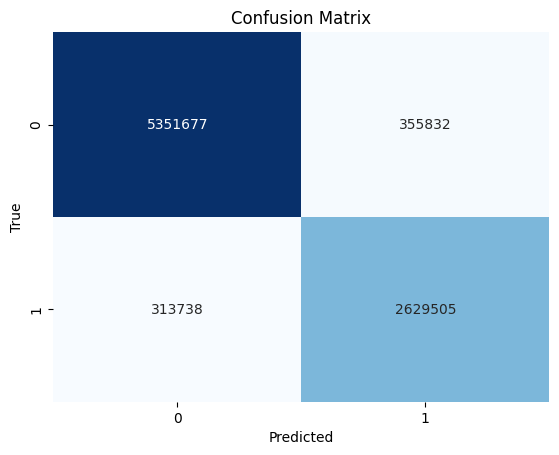

In [28]:
# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
report = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


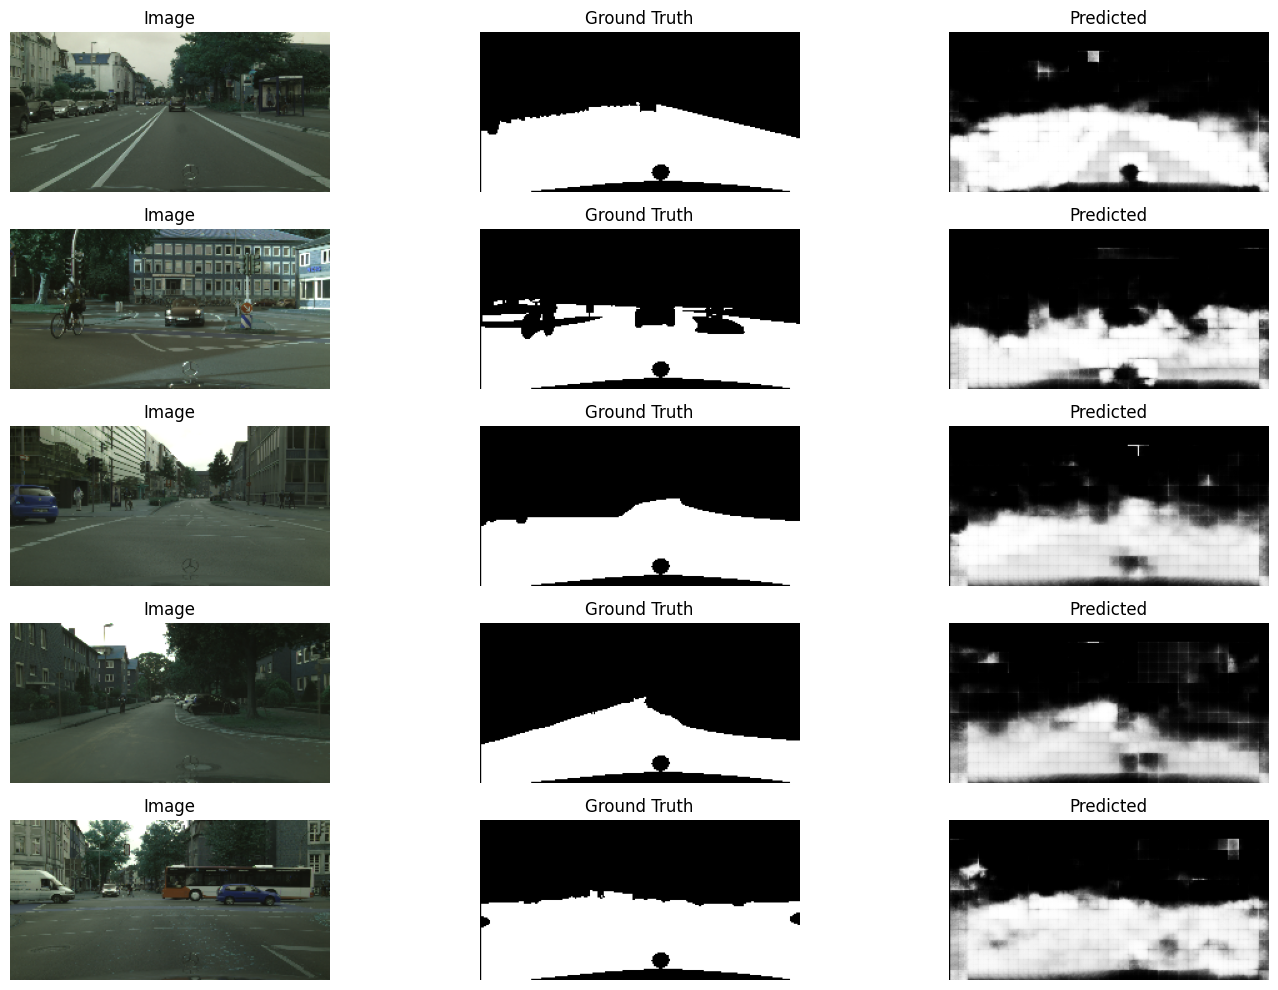

In [30]:
X_val_sample, y_val_sample = next(val_generator)

# Predict on the validation data
y_pred_sample = model.predict(X_val_sample)

def plot_images(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(X[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Predicted")

    plt.tight_layout()
    plt.show()

plot_images(X_val_sample, y_val_sample, y_pred_sample)

Processing image: ../data/personal_images/IMG_20241205_101544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


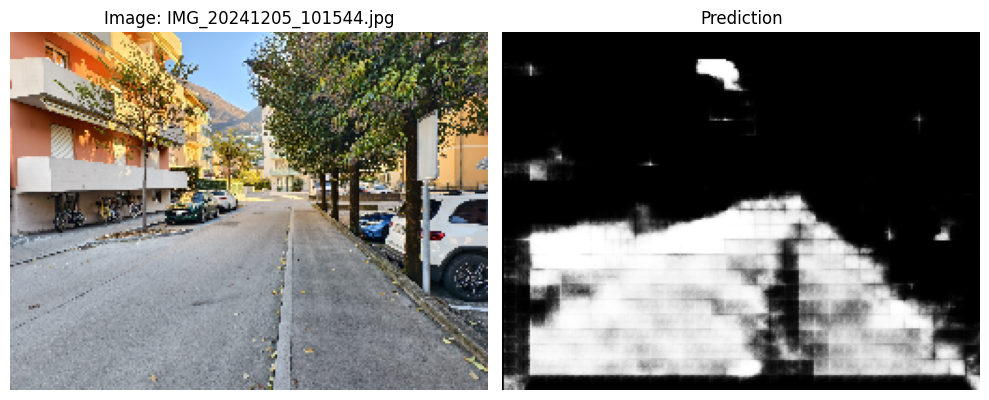

Processing image: ../data/personal_images/IMG_20241205_101454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


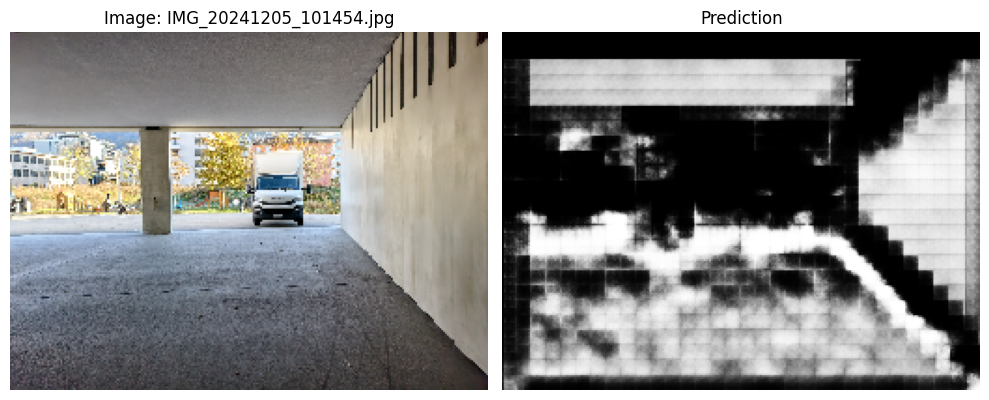

Processing image: ../data/personal_images/IMG_20241205_101509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


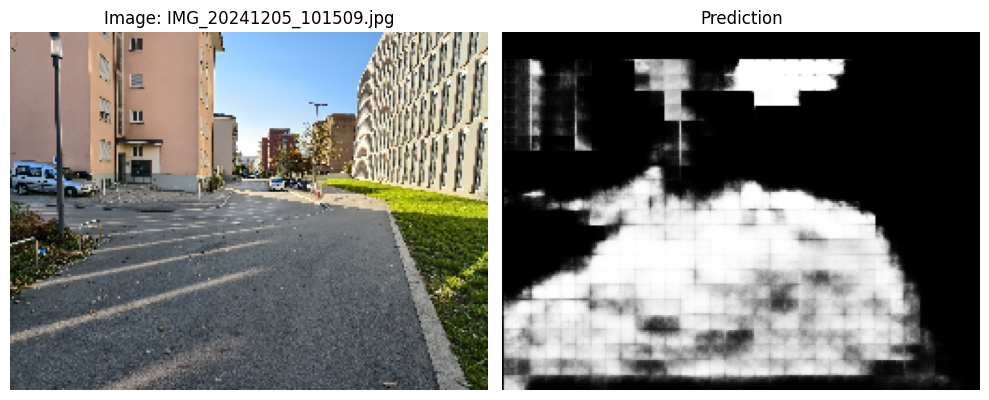

Processing image: ../data/personal_images/IMG_20241205_101535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


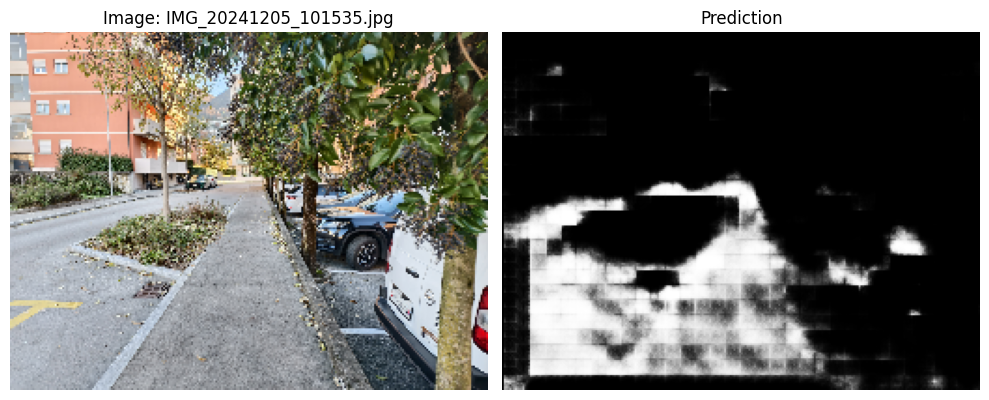

Processing image: ../data/personal_images/IMG_20241205_101519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


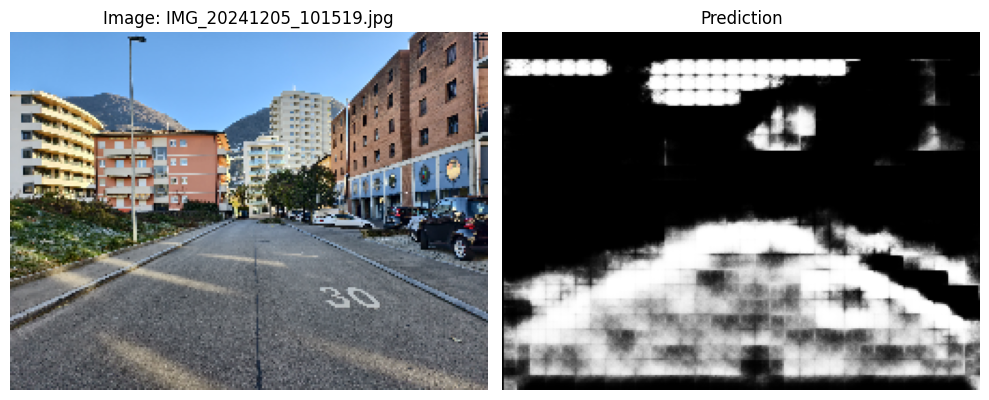

Processing image: ../data/personal_images/IMG_20241205_101701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


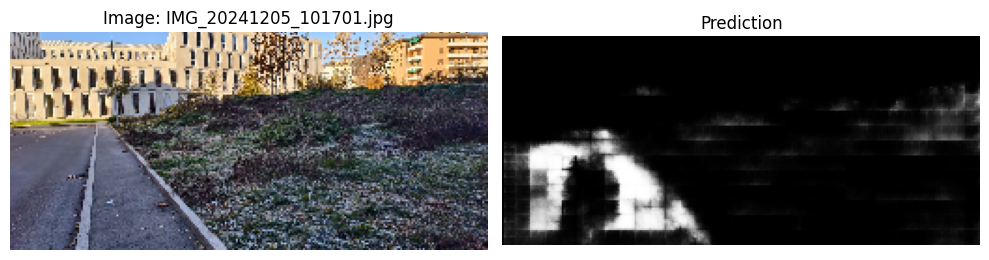

Processing image: ../data/personal_images/IMG_20241205_101703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


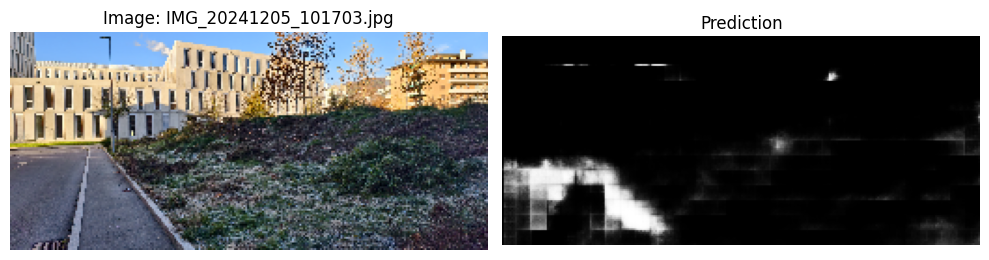

Processing image: ../data/personal_images/IMG_20241205_101717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


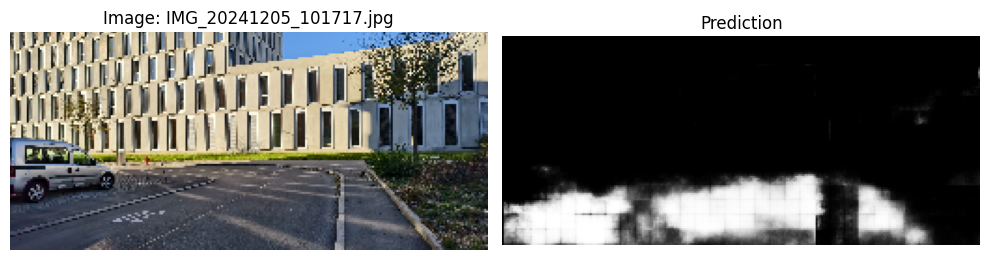

Processing image: ../data/personal_images/IMG_20241205_101528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


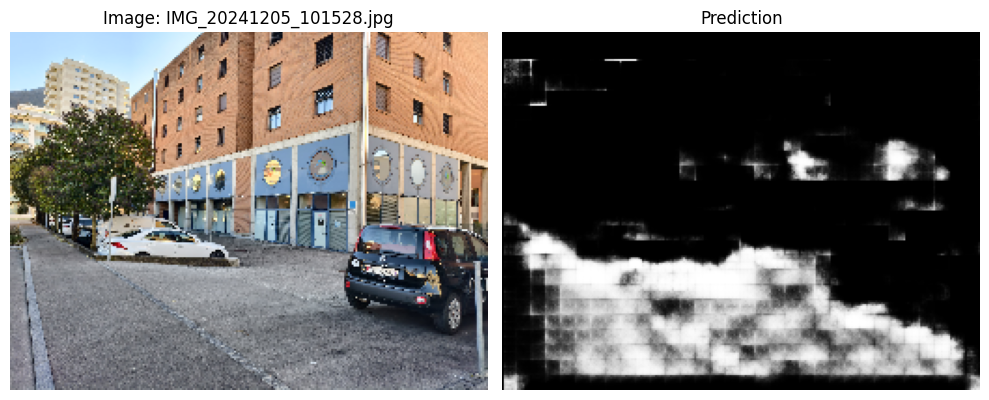

Processing image: ../data/personal_images/IMG_20241205_101706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


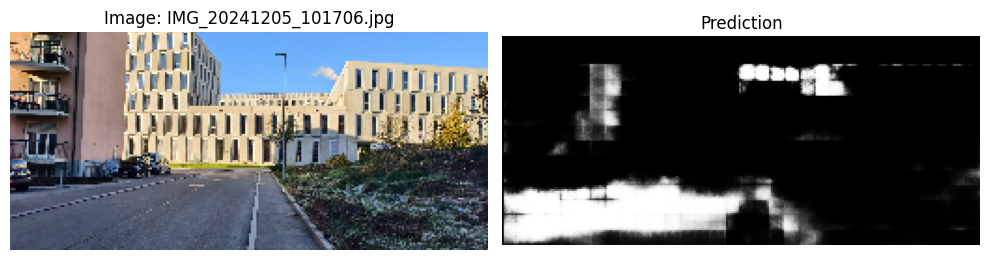

Processing image: ../data/personal_images/IMG_20241205_101511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


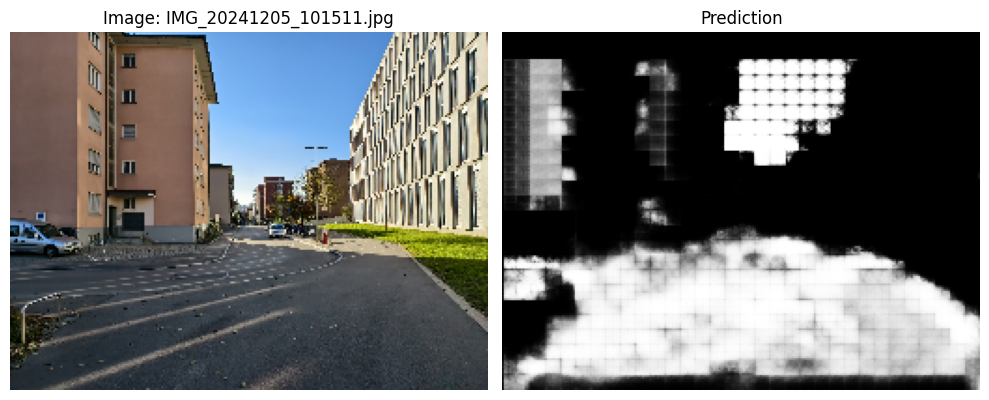

Processing image: ../data/personal_images/IMG_20241205_101604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


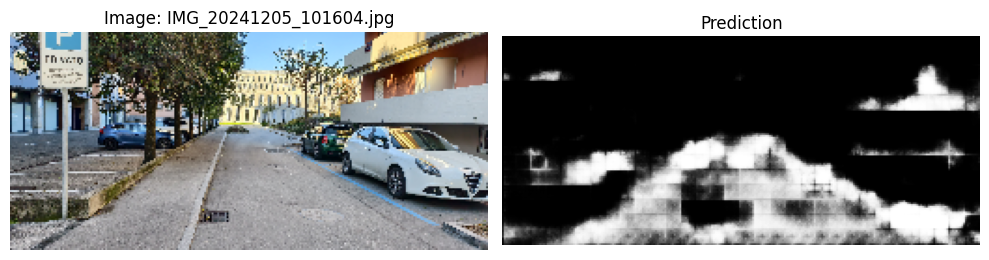

Processing image: ../data/personal_images/IMG_20241205_101558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


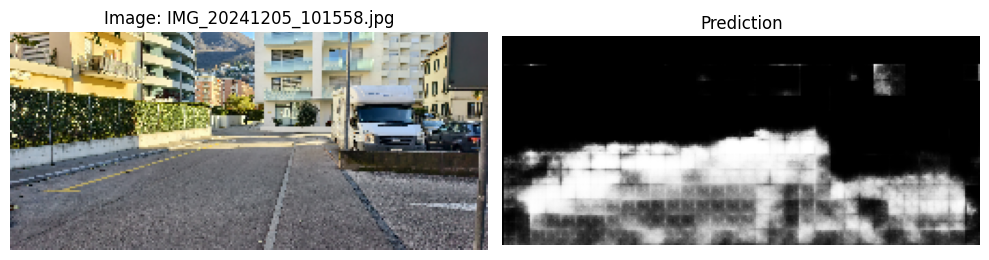

In [31]:
def predict_on_image(model, image_path, target_size=TARGET_SIZE):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Cannot read image from path: {image_path}")
    
    h, w = image.shape[:2]

    # Calculate new height based on aspect ratio
    target_height = int((target_size / w) * h)

    # Resize the image
    image_resized = cv2.resize(image, (target_size, target_height))
    prediction = model.predict(np.expand_dims(image_resized, axis=0))
    return image_resized, prediction

# Define the path to the 'personal_images' folder
image_folder = os.path.join('..','data', 'personal_images')

# Iterate over all images in the 'personal_images' folder
for image_name in os.listdir(image_folder):
    # Check if the file is an image (you can add more formats if needed)
    if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_folder, image_name)
        print(f"Processing image: {image_path}")
        
        # Get the image and prediction
        image_resized, prediction = predict_on_image(model, image_path, target_size=TARGET_SIZE)
        
        # Plot the image and prediction
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.axis('off')
        plt.title(f"Image: {image_name}")
        
        plt.subplot(1, 2, 2)
        plt.imshow(prediction.squeeze(), cmap='gray')  # Assuming the prediction is a single-channel image
        plt.axis('off')
        plt.title("Prediction")
        
        plt.tight_layout()
        plt.show()
